# RTBP Problem  experiments

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-RTBP">
             Initial value problem: RTBP</a></li>

<li><a href="#Ode-problem">
             Ode problem</a></li>

<li><a href="#Error-in-energy">
             Error in energy</a></li> 

<li><a href="#Work-Precision-diagrams">
             Work-Precision diagrams</a></li> 

</ul>  

## Loading packages

In [2]:
using OrdinaryDiffEq,DiffEqDevTools,BenchmarkTools
using IRKGaussLegendre
using Plots,LinearAlgebra
using Dates
using JLD2, FileIO

In [3]:
#plotly()

<a href="#top">Back to the top</a>

## Computer properties

In [4]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

1

In [5]:
#;cat /proc/cpuinfo # on Linux machines

In [6]:
using Hwloc
Hwloc.num_physical_cores()

2

<a href="#top">Back to the top</a>

## Initial value problem:  RTBP

In [7]:
setprecision(BigFloat, 108);
include("../examples/RTBP.jl")
include("../examples/InitialRTBP.jl")


# Periodo bat!! !!!

t0=0.0
t1=parse(Float64,"17.0652165601579625588917206249")

u064,μ64 =InitialRTBP(Float64)
lpp=[μ64]
tspan64=(t0,2*t1)
prob64 = ODEProblem(f,u064,tspan64,[μ64]);

u0128,μ128=InitialRTBP(BigFloat)
tspan128=(BigFloat(t0),2*parse(BigFloat,"17.0652165601579625588917206249"))
prob128 = ODEProblem(f,u0128,tspan128,μ128,;lpp=lpp);
(typeof(u064),typeof(μ64),typeof(tspan64),typeof(u0128),typeof(μ128),typeof(tspan128))

(Array{Float64,1}, Float64, Tuple{Float64,Float64}, Array{BigFloat,1}, BigFloat, Tuple{BigFloat,BigFloat})

<a href="#top">Back to the top</a>

## Test solution

In [8]:
#test_sol = TestSolution(tspan128,[u0128]);

In [9]:
setprecision(BigFloat, 256)
#sol =solve(prob128,Vern9(),save_everystep=false,abstol=1e-32,reltol=1e-32);
#@save "./Data/RTBP_test_solF128END.jld2" sol

@load "./Data/RTBP_test_solF128END.jld2" sol
test_sol = TestSolution(sol);
sol.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  1484322
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          92767
Number of rejected steps:                          3

<a href="#top">Back to the top</a>

## Float64 Computations (OdeProblem)

### Vern9 

In [10]:
sol9 =solve(prob64,Vern9(),abstol=1e-12,reltol=1e-12);
sol9.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  9138
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          534
Number of rejected steps:                          37

### IRKGL16 

In [11]:
(sol1,iters1,steps1) = solve(prob64,IRKGL16(), reltol=1e-12, abstol=1e-12, adaptive=true,myoutputs=true,
                             mixed_precision=false)
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  15582
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          137
Number of rejected steps:                          25

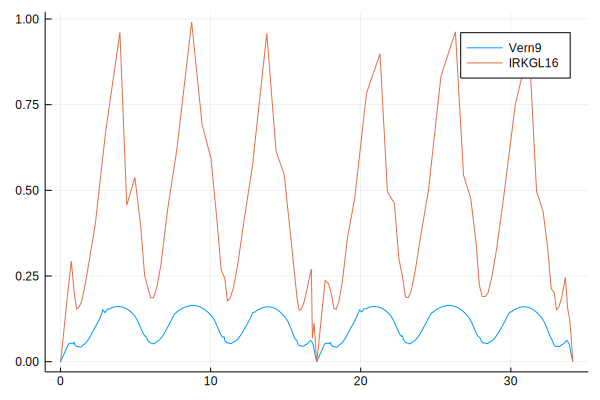

In [12]:
steps9 =sol9.t[2:end]-sol9.t[1:end-1]
plot(sol9.t[2:end],steps9, label="Vern9")
plot!(sol1.t,steps1, label="IRKGL16")

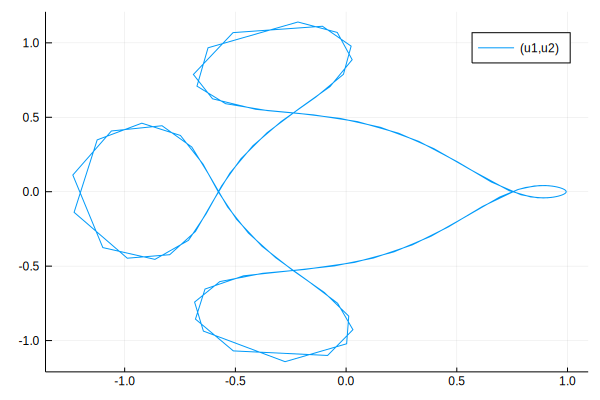

In [13]:
plot(sol1,vars=(1,2))

<a href="#top">Back to the top</a>

## Float128 Computations (OdeProblem)

In [14]:
setprecision(BigFloat, 108);

### Vern9

In [15]:
sol19 =solve(prob128,Vern9(),abstol=1e-20,reltol=1e-20);
sol19.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  65442
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          4087
Number of rejected steps:                          3

In [16]:
sol101 =solve(prob128,Vern9(),abstol=1e-26,reltol=1e-26);
sol101.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  303826
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          18986
Number of rejected steps:                          3

### IRKGL16 

In [ ]:
(sol11,iters11,steps11) = solve(prob128,IRKGL16(), reltol=1e-20, abstol=1e-20, adaptive=true,myoutputs=true,
                             mixed_precision=false)
sol11.destats

In [ ]:
(sol102,iters102,steps102) = solve(prob128,IRKGL16(), reltol=1e-26, abstol=1e-26, adaptive=true,myoutputs=true,
                             mixed_precision=false)
sol102.destats

### IRKGL16 (Mixed-Precision)

In [ ]:
(sol12,iters12,steps12) = solve(prob128,IRKGL16(),reltol=1e-12, abstol=1e-12,adaptive=true,myoutputs=true,
                              mixed_precision=true,low_prec_type=Float64)
sol12.destats

<a href="#top">Back to the top</a>

## Error in energy

In [ ]:
setprecision(BigFloat, 256)
u0256, μ256 =InitialRTBP(BigFloat)

E0=RTBPEnergy(u0256,μ256)

#ΔE = map(x->RTBPEnergy(BigFloat.(x),μ256), sol.u)./E0.-1
ΔE1 = map(x->RTBPEnergy(BigFloat.(x),μ256), sol1.u)./E0.-1
ΔE9 = map(x->RTBPEnergy(BigFloat.(x),μ256), sol9.u)./E0.-1
ΔE11 = map(x->RTBPEnergy(BigFloat.(x),μ256), sol11.u)./E0.-1
ΔE12 = map(x->RTBPEnergy(BigFloat.(x),μ256), sol12.u)./E0.-1
ΔE19 = map(x->RTBPEnergy(BigFloat.(x),μ256), sol19.u)./E0.-1
ΔE101 = map(x->RTBPEnergy(BigFloat.(x),μ256), sol101.u)./E0.-1
ΔE102 = map(x->RTBPEnergy(BigFloat.(x),μ256), sol102.u)./E0.-1
(Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE9))) ,Float32(maximum(abs.(ΔE11))),Float32(maximum(abs.(ΔE12))) ,Float32(maximum(abs.(ΔE19))))

In [ ]:
ylimit1=-28
ylimit2=-12
plot(sol1.t,log10.(abs.(ΔE1)), label="IRKGL16-F64",title="Float64",
     ylims=(ylimit1,ylimit2),)
plot!(sol9.t,log10.(abs.(ΔE9)), label="Vern9",
     ylims=(ylimit1,ylimit2),)

In [ ]:
ylimit1=-28
ylimit2=-12
plot(sol11.t,log10.(abs.(ΔE11)), label="IRKGL16-F128",title="Float128",
     ylims=(ylimit1,ylimit2),)
plot!(sol12.t,log10.(abs.(ΔE12)), label="IRKGL16-Mixed: F128/F64",
     ylims=(ylimit1,ylimit2),)
plot!(sol19.t,log10.(abs.(ΔE19)), label="Vern9-F128",
     ylims=(ylimit1,ylimit2),)

In [ ]:
# tol=1e-26
#@show (Float32(maximum(abs.(ΔE101))),Float32(maximum(abs.(ΔE102))))
#apr101=appxtrue(sol101,test_sol)
#apr102=appxtrue(sol102,test_sol)
#@show (apr101.errors, apr102.errors);

In [ ]:
ylimit1=-34
ylimit2=-25
plot(sol101.t,log10.(abs.(ΔE101)), label="Vern9",title="tol=1e-26",
     ylims=(ylimit1,ylimit2),)
plot!(sol102.t,log10.(abs.(ΔE102)), label="IRKGL16",
     ylims=(ylimit1,ylimit2),)

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float64)

In [ ]:
Threads.nthreads()

In [ ]:
abstols = 1.0 ./ 10.0 .^ (10:17)
reltols = 1.0 ./ 10.0 .^ (10:17);

### Float64 (OdeProblem)

In [ ]:
setups = [
           Dict(:alg=>Vern9())
           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>false) 
]
wp1 = WorkPrecisionSet(prob64,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=1,maxiters=10000000)
plot(wp1)

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float128)

In [ ]:
setprecision(BigFloat, 108)
abstols = 1.0 ./ 10.0 .^ (12:30)
reltols = 1.0 ./ 10.0 .^ (12:30);

### Float128 (OdeProblem)

In [ ]:
setups = [ Dict(:alg=>Vern9())
           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>false) 
           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>true,:low_prec_type=>Float64)
]
wp11 = WorkPrecisionSet(prob128,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=1,maxiters=100000)
plot(wp11)

<a href="#top">Back to the top</a>